In [242]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MultipleLocator
import matplotlib.lines

import pandas as pd
import numpy as np
import os
import glob

In [243]:
def getDatasets(subFolder):
    return {
        os.path.basename(c)[:-4]: pd.read_csv(open(c), skipinitialspace=True)
        for c in glob.glob(os.path.join(OUTPUT_FOLDER, subFolder, '*.csv'))
    }

In [244]:
OUTPUT_FOLDER = 'output.2019.dic.11.14_37_16'


In [245]:
eventHandled = getDatasets('eventHandled')
eventReceived = getDatasets('eventReceived')
createEvent = getDatasets('createEvent')

retrieveTries = getDatasets('retrieveTries')
retrieveFail = getDatasets('retrieveFail')
retrieveFound = getDatasets('retrieveFound')

dead = pd.read_csv(open(os.path.join(OUTPUT_FOLDER, 'dead.csv')), skipinitialspace=True)

# Cleanup and useful calculation

In [246]:
allCreateEvent = pd.concat(createEvent.values())
lastRound = allCreateEvent['round'].max()
lastConsideredRound = lastRound-15
display(allCreateEvent)
consideredEvent = allCreateEvent.query(f'round < {lastConsideredRound}')['id']
consideredEvent

,id,timestamp,round
0,146,166.860214,7
1,194,211.995390,9
2,374,382.837824,14
3,406,408.133990,15
4,424,431.717198,16
...,...,...,...
188,10351,9728.810972,326
189,10376,9753.102033,327
190,10436,9810.632510,329
191,10583,9949.895198,333


0        146
1        194
2        374
3        406
4        424
       ...  
177     9813
178    10013
179    10033
180    10113
181    10117
Name: id, Length: 10144, dtype: object

In [247]:
nodes = dead['id']

In [248]:
allEventHandled = pd.concat(eventHandled.values(), keys=eventHandled.keys(), names=["receiver"])
allEventHandled

id    timestamp round
receiver                                                            
809915f6-bc36-4a59-b8bb-78374e6d103d 0         14    60.010757     4
                                     1         27    90.010411     5
                                     2         28    90.010411     5
                                     3         25    90.010411     5
                                     4          8    90.011918     5
...                                           ...          ...   ...
03716fb4-b3c3-4673-98f6-33f4c0acfdf5 10756  10582  9990.017426   335
                                     10757  10576  9990.017426   335
                                     10758  10568  9990.017426   335
                                     10759  10584  9990.017426   335
                                     10760  10589  9990.017426   335

[643627 rows x 3 columns]

In [249]:
allEventReceived = pd.concat(eventReceived.values(), keys=eventReceived.keys(), names=["receiver"])

In [250]:
eventsPerRound = allCreateEvent.groupby('round').size().reset_index().set_index('round').rename(columns={0: 'number'})
eventsPerRound

,number
round,
3,32
4,32
5,32
6,32
7,32
...,...
331,32
332,32
333,32


In [251]:
EVENTS_SIZE = eventsPerRound['number'].mean()
GOSSIP_INTERVAL = 30
NODE_COUNT = dead['id'].count()

# Number of infected

In [26]:
j = allEventHandled.reset_index().set_index('id') \
                   .join(allCreateEvent.set_index('id'), lsuffix='_handled', rsuffix='_created')
j = j.reset_index()
j = j[j.id.isin(consideredEvent)]
j = j[['id', 'receiver','timestamp_handled', 'timestamp_created']]
j['timestamp'] = j['timestamp_handled'] - ((j['timestamp_created']/30).astype('int32')+1)*30
j = j[j.timestamp_created < 210]

In [ ]:
lastId = j.max()['id']
area_inf = pd.DataFrame(columns=['timestamp', 'number', 'std', 'max', 'min'])

j2 = j

for i in range(0, lastRound):
    j2 = j2[j2.timestamp < (lastRound-i)*30 + 5]
    k = np.array([j2[(j2.id == p)].drop_duplicates('receiver')['id'].count() for p in range(1,lastId+1)])

    area_inf.loc[i] = [(lastRound-i)*30, k.mean(), k.std(), k.max(), k.min()]
    
area_inf

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_axes([0,0,1,1])
ax1.set_title('#Infected processes vs time')
ax1.set_xlabel('time (s) with 1 round = 30s')
ax1.set_ylabel('#infected processes')

ax1.xaxis.set_major_locator(MultipleLocator(GOSSIP_INTERVAL))

#ax1.xaxis.set_major_locator(MultipleLocator(GOSSIP_INTERVAL*3))
#ax1.xaxis.set_minor_locator(MultipleLocator(GOSSIP_INTERVAL))

for i in range(1, lastId+1,int(lastId/10)):
    t = j[j.id==i].sort_values('timestamp').drop_duplicates('receiver')
    ax1.plot(t['timestamp'], range(1, t.count()['id']+1), '--', linewidth=1, marker='x', markersize=3, label=f'id={i}')

plt.autoscale(False)
plt.axhline(y=NODE_COUNT, linestyle='--', c='grey')
plt.fill_between(area_inf['timestamp'], area_inf['min'], area_inf['max'], label='min-max', alpha=0.2, facecolor='blue')
plt.fill_between(area_inf['timestamp'], area_inf['number'] + area_inf['std'], area_inf['number'] - area_inf['std'], label='std', alpha=0.2, facecolor='red')
plt.plot(area_inf['timestamp'], area_inf['number'], '-', label='mean')

ax1.legend()

#plt.show()

plt.savefig(OUTPUT_FOLDER.replace('.','_').replace('/','') + '.svg')

# Delivery ratio

In [ ]:
data = (allEventHandled.reset_index().drop_duplicates(['round', 'receiver', 'id']) \
                       .groupby(['round', 'receiver']) \
                       .size() \
                       .groupby('round').mean()) \
        .reset_index() \
        .set_index('round') \
        .rename(columns={0: 'deliveries'}) \
        .join(eventsPerRound)
data['deliveryRatio'] = data['deliveries']/EVENTS_SIZE

data = data.reset_index()[['round', 'deliveryRatio']]
data

In [ ]:
data['deliveryRatio'].describe()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Delivery ratio in time')
ax.set_xlabel('Round')
ax.set_ylabel('Delivery ratio')

plt.axhline(y=data['deliveryRatio'].mean(), linestyle='--', c='grey')
plt.axhline(y=1, linestyle='--', linewidth=1, c='black')

ax.plot(data['round'], data['deliveryRatio'], label='Uniform + random')

ax.legend()
plt.show()

# Redundancy

In [ ]:
final = pd.DataFrame(columns=['round', 'redundancy'])

for node in nodes:
    currentEventReceived = eventReceived[node]
    currentEventHandled = eventHandled[node]

    evEh = currentEventReceived.groupby('id').min().reset_index()[['id', 'timestamp']].set_index('id')
    w = currentEventReceived \
        .set_index('id') \
        .join(
            evEh, 
            lsuffix='_received', 
            rsuffix='_handled') \
        .query('timestamp_received > timestamp_handled') \
        .groupby('round') \
        .size() \
        .reset_index() \
        .set_index('round') \
        .join(currentEventReceived.groupby('round').size().reset_index().set_index('round'), 
              lsuffix='_redundant',
              rsuffix='_total') \
        .reset_index()

    w['redundancy'] = w['0_redundant']/w['0_total']
    w = w[['round', 'redundancy']]
    
    final = pd.concat([final,w])
    
final = final.groupby('round') \
             .mean() \
             .reset_index()

In [ ]:
final['redundancy'].describe()


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Redundancy in time')
ax.set_xlabel('Round')
ax.set_ylabel('Redundancy')

ax.plot(final['round'], final['redundancy'], label='Uniform + random', color='red')
ax.axhline(final['redundancy'][15:].mean(), linestyle='--', color='red')

ax.legend()
plt.show()

# Reliability

In [252]:
def prepare(i, timestamp):
    return set(dead[(dead.timestamp < 0) | (dead.timestamp > timestamp + GOSSIP_INTERVAL*15)]['id'])

def p(i, r):
    return r in aliveForMessageId[i]
    
aliveForMessageId = {l.id: prepare(l.id, l.timestamp) for index, l in allCreateEvent.iterrows()}

In [253]:
w = allEventHandled.reset_index()
w = w[w.id.isin(consideredEvent)]
w = w[[p(r['id'], r['receiver']) for _i, r in w.iterrows()]]
w = w.reset_index().sort_values('timestamp').drop_duplicates(['receiver', 'id']).groupby('id').size().reset_index().rename(columns={0: 'nHandled'})
w['nAlive'] = [len(aliveForMessageId[i]) for i in w.id]

In [254]:
w['ratio'] = w['nHandled'] / w['nAlive']
w['ratio'].describe()

count    10144.000000
mean         0.997514
std          0.024568
min          0.100000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: ratio, dtype: float64

# Throughput

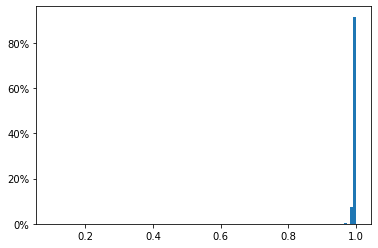

In [255]:
plt.hist(w['ratio'], weights=np.ones(len(w))/len(w), bins=100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [256]:
sum(w['nHandled'] == w['nAlive']) / w['id'].count()

0.9151222397476341

# Retrieve ratio

# Tests

In [ ]:
# Non opt
# % non opt 15 view 11_15
#     % count    4120.000000
#     % mean        0.852454
#     % std         0.173371
#     % min         0.040000
#     % max         1.000000
# % non opt 20 view 11_19
#     % count    4160.000000
#     % mean        0.855604
#     % std         0.171855
#     % min         0.040000
#     % max         1.000000
# % non opt 25 view 11_23
#     % count    4280.000000
#     % mean        0.860574
#     % std         0.170947
#     % min         0.040000
#     % max         1.000000
# % non opt 30 view 11_28
#     % count    4320.000000
#     % mean        0.861374
#     % std         0.171638
#     % min         0.040000
#     % max         1.000000
# % non opt 35 view 11_33
#     % count    4320.000000
#     % mean        0.859694
#     % std         0.174771
#     % min         0.040000
#     % max         1.000000

# Opt
# % opt 15 view 11_40
#     % count    12960.000000
#     % mean         0.964959
#     % std          0.065632
#     % min          0.040000
#     % max          1.000000
# % opt 20 view 12_19
#     % count    13320.000000
#     % mean         0.964506
#     % std          0.075456
#     % min          0.040000
#     % max          1.000000
# % opt 25 view 12_26
#     % count    13800.000000
#     % mean         0.968791
#     % std          0.069442
#     % min          0.040000
#     % max          1.000000
# % opt 30 view 12_39
#     % count    13960.000000
#     % mean         0.969332
#     % std          0.070489
#     % min          0.040000
#     % max          1.000000
# % opt 35 view 12_46
#     % count    14360.000000
#     % mean         0.970022
#     % std          0.079817
#     % min          0.040000
#     % max          1.000000

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x = [15, 20, 25, 30, 35]
ynopt = np.array([0.852454, 0.855604, 0.860574, 0.861374, 0.859694])
stdnopt = np.array([0.173371, 0.171855, 0.170947, 0.171638, 0.174771])

yopt = np.array([0.964959, 0.964506, 0.968791, 0.969332, 0.970022])
stdopt = np.array([0.065632, 0.075456, 0.069442, 0.070489, 0.079817])

plt.plot(x, ynopt, label='Not optimized', marker='x', color='tab:blue')
plt.plot(x, yopt, label='Optimized', marker='x', color='tab:orange')

plt.fill_between(x, ynopt + stdnopt, ynopt - stdnopt, label='std unoptimized', alpha=0.2, facecolor='tab:blue')
plt.fill_between(x, yopt + stdopt, yopt - stdopt, label='std optimized', alpha=0.2, facecolor='tab:orange')

ax.set_title('Reliability vs view size')
ax.set_xlabel('View size')
ax.set_ylabel('Reliability')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.legend()

plt.savefig('rvv.svg')

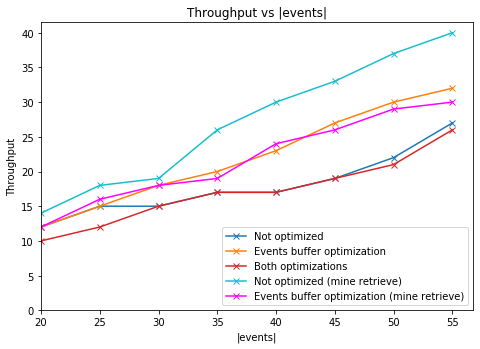

In [265]:
# 60 node_count
# 0.59 initial_view_perc

# 120 event_ids_size

# 0.1 dropped_rate

# 0.05 death_rate

# 0.013 mean_latency
# 0.003 var_latency

# 0 events_var_rate

# 10 subs_size
# 5 un_subs_size
# 15 views_size
# 4 fanout_size
# 1 k

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x = [20, 25, 30, 35, 40, 45, 50, 55]#, 60]

ynopt = np.array([12, 15, 15, 17, 17, 19, 22, 27])
yopt = np.array([12, 15, 18, 20, 23, 27, 30, 32])
yopt_and_sub  = np.array([10, 12, 15, 17, 17, 19, 21, 26])

rt_ynopt = np.array([14, 18, 19, 26, 30, 33, 37, 40])
rt_yopt = np.array([12, 16, 18, 19, 24, 26, 29, 30])



plt.plot(x, ynopt, label='Not optimized', marker='x', color='tab:blue')
plt.plot(x, yopt, label='Events buffer optimization', marker='x', color='tab:orange')
plt.plot(x, yopt_and_sub, label='Both optimizations', marker='x', color='tab:red')

plt.plot(x, rt_ynopt, label='Not optimized (mine retrieve)', marker='x', color='tab:cyan')
plt.plot(x, rt_yopt, label='Events buffer optimization (mine retrieve)', marker='x', color='magenta')

ax.set_title('Throughput vs |events|')
ax.set_xlabel('|events|')
ax.set_ylabel('Throughput')
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.xlim(left=20)
plt.ylim(bottom=0)

ax.legend()

plt.savefig('th.svg')

## Delivery and redundancy

In [ ]:
non_opt_deliveryRatio = (data['round'], data['deliveryRatio'])
non_opt_redundancy = (final['round'], final['redundancy'])

In [ ]:
opt_deliveryRatio = (data['round'], data['deliveryRatio'])
opt_redundancy = (final['round'], final['redundancy'])

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Redundancy in time')
ax.set_xlabel('Round')
ax.set_ylabel('Redundancy')

ax.plot(non_opt_redundancy[0], non_opt_redundancy[1], label='With failures', color='tab:blue')
ax.axhline(non_opt_redundancy[1][15:].mean(), linestyle='--', color='tab:blue')

ax.plot(opt_redundancy[0], opt_redundancy[1], label='Without failures (both system and message)', color='tab:orange')
ax.axhline(opt_redundancy[1][15:].mean(), linestyle='--', color='tab:orange')

ax.legend()
plt.savefig('rd.svg')

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Delivery ratio in time')
ax.set_xlabel('Round')
ax.set_ylabel('Delivery ratio')

plt.axhline(y=1, linestyle='--', linewidth=1, c='black')

ax.plot(non_opt_deliveryRatio[0], non_opt_deliveryRatio[1], label='With failures', color='tab:blue')
plt.axhline(y=non_opt_deliveryRatio[1].mean(), linestyle='--', color='tab:blue')

ax.plot(opt_deliveryRatio[0], opt_deliveryRatio[1], label='Without failures (both system and message)', color='tab:orange')
plt.axhline(y=opt_deliveryRatio[1].mean(), linestyle='--', color='tab:orange')

ax.legend()
plt.savefig('drr.svg')

In [ ]:
1. > float('nan')